In [ ]:
import pytensor.tensor as pt
from pytensor.scan import scan

# ---- GARCH recursion: h_t = sigma_t^2 (elementwise) ----
h0 = omega / pt.clip(1.0 - (alpha + beta), 1e-4, np.inf)   # (n,)

def h_step(x_tm1_t, x_tm2_t, h_tm1, c, a, b, w, phi):
    # mu_{t-1} = c + phi * x_{t-2}  -> innovation at t-1:
    innov_sq = (x_tm1_t - c - phi * x_tm2_t) ** 2          # (n,)
    return w + a * innov_sq + b * h_tm1                    # (n,)

h_seq, _ = scan(
    fn=h_step,
    sequences=[X_tm1_d, X_tm2_d],          # each (T_eff, n)
    outputs_info=[h0],                     # (n,)
    non_sequences=[c, alpha, beta, omega, phi],
)

h_seq     = pt.maximum(h_seq, EPS)         # (T_eff, n)
sigma_seq = pt.sqrt(h_seq)                 # (T_eff, n)

# ---- Mean at time t ----
mu_seq = c + phi * X_tm1_d                 # (T_eff, n)

# ---- Batch chol for Sigma_t = D_t R D_t ----
# KEY: no Python loops, no pt.stack(list(...))
# Scaling rows of L_R by sigma_t equals D_t @ L_R
chol_stack = sigma_seq[:, :, None] * L_R   # (T_eff, n, n)

X_obs = pm.MvNormal(
    "X_obs",
    mu=mu_seq,                 # (T_eff, n)
    chol=chol_stack,           # (T_eff, n, n)
    observed=X_t_d,
    dims=("time","series"),
)


In [ ]:
# CCC-GARCH(1,1) with AR(1) means in PyMC — easy, correct, and PPC-ready
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
from aesara.scan import scan

# --- Data prep: df is a (T, n) DataFrame with DateIndex and series as columns
df = df.sort_index()
X_full = df.to_numpy(dtype=np.float64)   # (T, n)
T, n = X_full.shape

# Build lagged matrices: we start likelihood at t=2 (0-based)
X_tm2 = X_full[:-2]      # (T-2, n)
X_tm1 = X_full[1:-1]     # (T-2, n)
X_t   = X_full[2:]       # (T-2, n)
T_eff = X_t.shape[0]

EPS = 1e-8
coords = {"series": np.array(df.columns), "time": np.arange(T_eff)}

with pm.Model(coords=coords) as mgarch_model:
    # ---- Mutable data (so we can reuse the model for forecasting) ----
    X_tm2_d = pm.MutableData("X_tm2", X_tm2, dims=("time","series"))
    X_tm1_d = pm.MutableData("X_tm1", X_tm1, dims=("time","series"))
    X_t_d   = pm.MutableData("X_t",   X_t,   dims=("time","series"))

    # ---- Priors (per series) ----
    c     = pm.Normal("c",    mu=100.0, sigma=20.0, shape=n, dims=("series",))
    phi   = pm.Normal("phi",  mu=0.0,   sigma=0.5, shape=n, dims=("series",))
    omega = pm.TruncatedNormal("omega", mu=100.0, sigma=20.0, lower=EPS, shape=n, dims=("series",))
    alpha = pm.Beta("alpha",  alpha=5.0, beta=2.0, shape=n, dims=("series",))
    beta  = pm.Beta("beta",   alpha=2.0, beta=5.0, shape=n, dims=("series",))

    # Soft stationarity preference: alpha + beta < 1
    pm.Potential(
        "stationarity_barrier",
        at.sum(pm.math.log(at.clip(1.0 - (alpha + beta), EPS, 1.0)))
    )

    # ---- Constant correlation for standardized shocks ----
    R   = pm.LKJCorr("R", n=n, eta=1.0)          # correlation
    L_R = at.linalg.cholesky(R)                  # (n, n)

    # ---- GARCH recursion: h_t = sigma_t^2 (elementwise by series) ----
    # Start at unconditional variance
    h0 = omega / at.clip(1.0 - (alpha + beta), 1e-4, np.inf)     # (n,)

    # Step uses the AR(1) mean at t-1: mu_{t-1} = c + phi * X_{t-2}
    def h_step(x_tm1_t, x_tm2_t, h_tm1, c, alpha, beta, omega, phi):
        innov_sq = (x_tm1_t - c - phi * x_tm2_t) ** 2            # (n,)
        h_t = omega + alpha * innov_sq + beta * h_tm1            # (n,)
        return h_t

    h_seq, _ = scan(
        fn=h_step,
        sequences=[X_tm1_d, X_tm2_d],            # each (T_eff, n)
        outputs_info=[h0],                       # (n,)
        non_sequences=[c, alpha, beta, omega, phi],
    )
    h_seq     = at.maximum(h_seq, EPS)           # (T_eff, n)
    sigma_seq = at.sqrt(h_seq)                   # (T_eff, n)

    # ---- Mean at time t ----
    mu_seq = c + phi * X_tm1_d                   # (T_eff, n)

    # ---- Time-varying MVN likelihood ----
    # For each t, Sigma_t = D_t R D_t with D_t = diag(sigma_t).
    # Build batch cholesky with shape (T_eff, n, n):
    D_stack   = at.stack([at.diag(s) for s in sigma_seq], axis=0)   # (T_eff, n, n)
    chol_stack = D_stack @ L_R                                      # (T_eff, n, n)

    # Named likelihood so PPC produces draws of X_t
    X_obs = pm.MvNormal(
        "X_obs",
        mu=mu_seq,                 # (T_eff, n)
        chol=chol_stack,           # (T_eff, n, n)
        observed=X_t_d,
        dims=("time","series"),
    )

    # ---- Inference ----
    idata = pm.sample(
        draws=1000,
        tune=1500,
        chains=4,
        target_accept=0.9,
        random_seed=42,
    )

# ---------- Posterior predictive: 1-step-ahead forecast ----------
# Use the last two observed rows as lags; reuse the same model graph.
x_T   = X_full[-1][None, :]   # shape (1, n)
x_Tm1 = X_full[-2][None, :]

with mgarch_model:
    # Provide a single time step for lags; X_t can be dummy (not used as observed in PPC)
    pm.set_data({
        "X_tm1": x_T,          # becomes time=1
        "X_tm2": x_Tm1,
        "X_t":   np.zeros_like(x_T),   # placeholder
    })
    ppc = pm.sample_posterior_predictive(idata, var_names=["X_obs"])

# ppc["X_obs"] has shape (draws, time=1, n). Example summary:
one_step_draws = ppc["X_obs"][:, 0, :]          # (S, n)
one_step_mean  = one_step_draws.mean(axis=0)    # (n,)
one_step_q05   = np.quantile(one_step_draws, 0.05, axis=0)
one_step_q95   = np.quantile(one_step_draws, 0.95, axis=0)
print("1-step mean per series:", one_step_mean)


In [ ]:
# ===== CCC-GARCH(1,1) with AR(1) means in PyMC =====
# df: pandas DataFrame, shape (T, n) with dates as index and series IDs as columns

import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
from aesara.scan import scan

# -------- Data prep --------
df = df.sort_index()
X_full = df.to_numpy(dtype=np.float64)   # (T, n)
T, n = X_full.shape

# We need X_{t-2}, X_{t-1}, X_t  -> start likelihood at t=2
X_tm2 = X_full[:-2]     # (T-2, n)
X_tm1 = X_full[1:-1]    # (T-2, n)
X_t   = X_full[2:]      # (T-2, n)
T_eff = X_t.shape[0]
EPS = 1e-8

coords = {"series": np.array(df.columns), "time": np.arange(T_eff)}

with pm.Model(coords=coords) as mgarch_model:
    # Make data mutable in case you later want to forecast without rebuilding
    X_tm2_data = pm.MutableData("X_tm2", X_tm2, dims=("time","series"))
    X_tm1_data = pm.MutableData("X_tm1", X_tm1, dims=("time","series"))
    X_t_data   = pm.MutableData("X_t",   X_t,   dims=("time","series"))

    # ----- Priors (per series) -----
    # Your choices:
    c     = pm.Normal("c",    mu=100.0, sigma=20.0, shape=n, dims=("series",))
    phi   = pm.Normal("phi",  mu=0.0,   sigma=0.5, shape=n, dims=("series",))
    omega = pm.TruncatedNormal("omega", mu=100.0, sigma=20.0, lower=EPS, shape=n, dims=("series",))
    alpha = pm.Beta("alpha",  alpha=5.0, beta=2.0, shape=n, dims=("series",))
    beta  = pm.Beta("beta",   alpha=2.0, beta=5.0, shape=n, dims=("series",))

    # Soft stationarity preference: alpha + beta < 1
    pm.Potential(
        "stationarity_barrier",
        at.sum(pm.math.log(at.clip(1.0 - (alpha + beta), EPS, 1.0)))
    )

    # ----- Constant correlation (CCC) -----
    # A valid correlation matrix for the standardized shocks z_t ~ N(0, R)
    # eta=1.0 ~ uniform over correlation matrices; increase (>1) to shrink toward independence.
    R   = pm.LKJCorr("R", n=n, eta=1.0)
    L_R = at.linalg.cholesky(R)

    # ----- Volatility recursion: h_t = sigma_t^2 -----
    # Initialize with unconditional variance of GARCH(1,1)
    h0 = omega / at.clip(1.0 - (alpha + beta), 1e-4, np.inf)  # (n,)

    def h_step(x_tm1_t, x_tm2_t, h_tm1, c, a, b, w):
        # elementwise over series
        innov_sq = (x_tm1_t - c - x_tm2_t) ** 2
        h_t = w + a * innov_sq + b * h_tm1
        return h_t  # (n,)

    h_seq, _ = scan(
        fn=h_step,
        sequences=[X_tm1_data, X_tm2_data],   # each (T_eff, n)
        outputs_info=[h0],                    # initial state (n,)
        non_sequences=[c, alpha, beta, omega]
    )
    h_seq     = at.maximum(h_seq, EPS)        # (T_eff, n)
    sigma_seq = at.sqrt(h_seq)                # (T_eff, n)

    # ----- Mean vector each time -----
    mu_seq = c + phi * X_tm1_data             # (T_eff, n)

    # ----- Time-varying MVN likelihood accumulated over t -----
    def logp_step(x_t, mu_t, sigma_t, L_R):
        D_t   = at.diag(sigma_t)              # (n, n)
        chol_t = D_t @ L_R                    # chol(Sigma_t) with Sigma_t = D_t R D_t
        return pm.MvNormal.dist(mu=mu_t, chol=chol_t).logp(x_t)  # scalar

    logp_seq, _ = scan(
        fn=logp_step,
        sequences=[X_t_data, mu_seq, sigma_seq],  # each (T_eff, n)
        non_sequences=[L_R]
    )

    pm.Potential("likelihood", at.sum(logp_seq))

    # ----- Inference -----
    idata = pm.sample(
        draws=1000,
        tune=1500,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

# ===== Optional: helper to simulate in-sample paths and/or 1-step-ahead forecasts =====
import numpy as np

def simulate_ccc_garch_paths(idata, X_full, steps=0, draw_z=True, seed=123):
    """
    From posterior draws, re-run the CCC-GARCH recursion.
    If draw_z=True, simulate stochastic paths; else return conditional means.
    Returns:
        - if steps == 0: a dict with last in-sample sigma and mu per draw
        - if steps > 0 : forecasts array with shape (steps, S, n) where S = posterior draws
    """
    rng = np.random.default_rng(seed)
    T, n = X_full.shape
    X_tm2 = X_full[:-2]
    X_tm1 = X_full[1:-1]
    X_t   = X_full[2:]
    T_eff = X_t.shape[0]

    post = idata.posterior
    # flatten chains x draws
    def flat(name):
        arr = np.asarray(post[name])
        return arr.reshape(-1, *arr.shape[2:])  # (S, ...)

    c     = flat("c")        # (S, n)
    phi   = flat("phi")      # (S, n)
    omega = flat("omega")    # (S, n)
    alpha = flat("alpha")    # (S, n)
    beta  = flat("beta")     # (S, n)
    R     = flat("R")        # (S, n, n)
    S = c.shape[0]

    # init h_1
    h_tm1 = omega / np.clip(1.0 - (alpha + beta), 1e-4, np.inf)  # (S, n)

    # roll through in-sample period (to get last h and mean)
    for k in range(T_eff):
        x_tm1 = X_tm1[k]  # (n,)
        x_tm2 = X_tm2[k]  # (n,)
        innov_sq = (x_tm1 - c - x_tm2) ** 2
        h_t = omega + alpha * innov_sq + beta * h_tm1           # (S, n)
        h_tm1 = h_t

    # values aligned with last observed X_t
    sigma_last = np.sqrt(np.maximum(h_tm1, 1e-8))               # (S, n)
    mu_last    = c + phi * X_full[-2]                           # (S, n)

    if steps == 0:
        return {"sigma_last": sigma_last, "mu_last": mu_last}

    # multi-step ahead
    forecasts = []
    x_prev  = X_full[-1].copy()    # X_T
    x_prev2 = X_full[-2].copy()    # X_{T-1}
    for _ in range(steps):
        innov_sq = (x_prev - c - x_prev2) ** 2
        h_t = omega + alpha * innov_sq + beta * h_tm1
        sigma_t = np.sqrt(np.maximum(h_t, 1e-8))                 # (S, n)
        mu_t    = c + phi * x_prev                               # (S, n)

        if draw_z:
            z = np.stack([rng.multivariate_normal(mean=np.zeros(n), cov=R[s]) for s in range(S)])  # (S, n)
            x_new = mu_t + sigma_t * z                           # elementwise scale per series
        else:
            x_new = mu_t                                         # conditional mean (deterministic)

        forecasts.append(x_new)                                   # (S, n)
        # roll window
        x_prev2 = x_prev
        x_prev  = x_new.mean(axis=0) if draw_z else x_new.mean(axis=0)
        h_tm1   = h_t

    return np.stack(forecasts, axis=0)  # (steps, S, n)


In [ ]:

"""
Joint MLE for CCC-GARCH with AR(1)-GARCH(1,1) mean/variance per series.

Model:
    X_{i,t} = mu_i + phi_i X_{i,t-1} + eps_{i,t},  eps_{i,t} = sigma_{i,t} z_{i,t}
    sigma_{i,t}^2 = omega_i + alpha_i eps_{i,t-1}^2 + beta_i sigma_{i,t-1}^2
    z_t ~ N(0, R) with constant correlation matrix R
    Cov_t = D_t R D_t, D_t = diag(sigma_{1,t},...,sigma_{k,t})

We jointly estimate all parameters theta = {(mu_i, phi_i, omega_i, alpha_i, beta_i)}_i and R.

Notes:
- We use a robust unconstrained reparameterization:
    * phi_i = tanh(phi_raw_i)             ensures |phi_i| < 1
    * omega_i = exp(omega_raw_i) + eps    ensures omega_i > 0
    * (alpha_i, beta_i) constructed so alpha_i >= 0, beta_i >= 0, alpha_i + beta_i < 1 - eps
      via two sigmoids with nesting.
    * R is built from an unconstrained lower-triangular matrix B (including diagonal). We set
      Q = B B^T (SPD), and then scale to correlation: R = D^{-1/2} Q D^{-1/2}, D = diag(Q).
      This guarantees a valid correlation matrix for any B.
- Innovations are multivariate Normal (for Student-t, extend the likelihood accordingly).

Usage:
    from joint_ccc_garch_mle import JointCCCGARCHMLE
    mle = JointCCCGARCHMLE()
    mle.fit(df)  # df: pivoted DataFrame (dates x series), no missing within the used sample
    print(mle.params_)   # DataFrame of per-series parameters
    print(mle.R_)        # Estimated correlation matrix
    print(mle.loglik_, mle.aic_, mle.bic_)
"""

from dataclasses import dataclass
from typing import Dict, Tuple, Optional
import numpy as np
import pandas as pd

try:
    from scipy.optimize import minimize
except Exception as e:
    raise ImportError("This module requires scipy. Please `pip install scipy`.")


_EPS = 1e-6  # numerical safety for positivity / stationarity


def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def _pack_params(mu, phi_raw, omega_raw, a_raw, b_raw, B_raw):
    """Flatten parameter blocks into a single vector."""
    return np.concatenate([mu, phi_raw, omega_raw, a_raw, b_raw, B_raw])


def _unpack_params(theta, k):
    """Inverse of _pack_params. Returns tuple of parameter blocks."""
    n_series_block = k
    idx = 0
    mu = theta[idx: idx + n_series_block]; idx += n_series_block
    phi_raw = theta[idx: idx + n_series_block]; idx += n_series_block
    omega_raw = theta[idx: idx + n_series_block]; idx += n_series_block
    a_raw = theta[idx: idx + n_series_block]; idx += n_series_block
    b_raw = theta[idx: idx + n_series_block]; idx += n_series_block
    # lower-triangular B has k*(k+1)/2 entries
    nB = k * (k + 1) // 2
    B_raw = theta[idx: idx + nB]; idx += nB
    assert idx == len(theta)
    return mu, phi_raw, omega_raw, a_raw, b_raw, B_raw


def _build_R_from_B(B_raw, k):
    """Build SPD correlation matrix from unconstrained lower-triangular params B_raw."""
    B = np.zeros((k, k))
    it = iter(B_raw)
    for i in range(k):
        for j in range(i + 1):
            B[i, j] = next(it)
    Q = B @ B.T  # SPD
    d = np.sqrt(np.clip(np.diag(Q), _EPS, None))
    Dinv = np.diag(1.0 / d)
    R = Dinv @ Q @ Dinv
    # Numerical symmetrization
    R = 0.5 * (R + R.T)
    # clip diagonal to 1 exactly
    np.fill_diagonal(R, 1.0)
    return R


def _series_params(phi_raw, omega_raw, a_raw, b_raw):
    """Transforms raw (unconstrained) params into (phi, omega, alpha, beta) with constraints."""
    phi = np.tanh(phi_raw)  # |phi| < 1
    omega = np.exp(omega_raw) + _EPS  # > 0

    s1 = _sigmoid(a_raw)  # (0,1)
    alpha = s1 * (1.0 - 2.0 * _EPS)  # < 1
    # beta depends on alpha so alpha + beta < 1 - eps
    s2 = _sigmoid(b_raw)
    beta = s2 * (1.0 - _EPS - alpha)
    # Guarantee strict constraint
    alpha = np.clip(alpha, 0.0, 1.0 - 2.0 * _EPS)
    beta = np.clip(beta, 0.0, 1.0 - _EPS - alpha)
    return phi, omega, alpha, beta


def _ll_ccc(df_values, k, mu, phi, omega, alpha, beta, R):
    """
    Compute the CCC-GARCH joint log-likelihood under Normal innovations.

    Args:
        df_values: ndarray shape (T, k) with aligned data, no NaNs, time increasing
    """
    X = df_values
    T = X.shape[0]
    # Build mean residuals eps_t per series
    # Need lagged X: use X_{t-1}, so first effective t is 1..T-1
    Xlag = np.roll(X, 1, axis=0)
    Xlag[0, :] = X[0, :]  # harmless; we'll drop t=0 anyway by masking
    eps = X - (mu + phi * Xlag)  # broadcasting
    # Initialize sigma2 with unconditional variance
    uncvar = omega / (1.0 - alpha - beta)  # safe by construction
    sigma2 = np.empty_like(eps)
    sigma2[0, :] = uncvar
    for t in range(1, T):
        sigma2[t, :] = omega + alpha * (eps[t-1, :] ** 2) + beta * sigma2[t-1, :]

    sigma = np.sqrt(np.clip(sigma2, _EPS, None))

    # Drop the first row to avoid dependence on initial conditions / lag
    eps = eps[1:, :]
    sigma = sigma[1:, :]
    T_eff = eps.shape[0]
    if T_eff <= 2:
        return -np.inf  # not enough data

    # Precompute R^{-1} and log|R|
    sign, logdetR = np.linalg.slogdet(R)
    if not (sign > 0):
        return -np.inf
    Rinv = np.linalg.inv(R)

    # Standardized residuals
    Z = eps / sigma
    quad = np.einsum('ti,ij,tj->t', Z, Rinv, Z)
    log_sig = 2.0 * np.log(sigma).sum(axis=1)  # 2*sum log sigma_i,t
    ll_t = -0.5 * (k * np.log(2.0 * np.pi) + logdetR + log_sig + quad)
    return float(np.sum(ll_t))


from dataclasses import dataclass

@dataclass
class FitResult:
    success: bool
    message: str
    n_iter: int


class JointCCCGARCHMLE:
    def __init__(self, maxiter: int = 500, random_state: Optional[int] = 0):
        self.maxiter = maxiter
        self.random_state = random_state

        self.params_: Optional[pd.DataFrame] = None
        self.R_: Optional[pd.DataFrame] = None
        self.loglik_: Optional[float] = None
        self.aic_: Optional[float] = None
        self.bic_: Optional[float] = None
        self.fit_result_: Optional[FitResult] = None

    def _initial_theta(self, X: np.ndarray) -> np.ndarray:
        """Reasonable starting values based on sample moments and common GARCH heuristics."""
        rng = np.random.RandomState(self.random_state)
        T, k = X.shape
        mu0 = np.mean(X, axis=0)
        phi0 = np.zeros(k)  # start at AR coeff 0
        var0 = np.var(X, axis=0, ddof=1) + 1e-6
        alpha0 = np.full(k, 0.05)
        beta0 = np.full(k, 0.90)
        omega0 = var0 * (1.0 - alpha0 - beta0)

        # Raw params (inverse transforms)
        phi_raw0 = np.arctanh(np.clip(phi0, -0.99, 0.99))
        omega_raw0 = np.log(np.maximum(omega0 - _EPS, 1e-8))
        a_raw0 = np.log(alpha0 / (1 - alpha0))
        # derive b_raw from beta0 target given alpha0
        beta_cap = 1.0 - _EPS - alpha0
        beta_frac = np.clip(beta0 / np.maximum(beta_cap, 1e-8), 1e-6, 1-1e-6)
        b_raw0 = np.log(beta_frac / (1 - beta_frac))

        # Correlation init via identity using B lower-triangular = identity
        B = np.eye(k)
        B_raw = []
        for i in range(k):
            for j in range(i + 1):
                B_raw.append(B[i, j])
        B_raw0 = np.array(B_raw)

        return _pack_params(mu0, phi_raw0, omega_raw0, a_raw0, b_raw0, B_raw0)

    def fit(self, df: pd.DataFrame):
        df = df.copy()
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.sort_index()

        # Require aligned, complete data (drop any rows with NaNs across series)
        df = df.astype(float).dropna(how="any")
        X = df.values
        T, k = X.shape
        if T < 50:
            raise ValueError("Not enough observations after dropping NaNs (need >= 50).")

        theta0 = self._initial_theta(X)

        def nll(theta):
            mu, phi_raw, omega_raw, a_raw, b_raw, B_raw = _unpack_params(theta, k)
            phi, omega, alpha, beta = _series_params(phi_raw, omega_raw, a_raw, b_raw)
            # Broadcast to (1,k) for vectorized arithmetic with X
            mu_b = mu.reshape((1, k))
            phi_b = phi.reshape((1, k))
            omega_b = omega.reshape((1, k))
            alpha_b = alpha.reshape((1, k))
            beta_b = beta.reshape((1, k))
            R = _build_R_from_B(B_raw, k)
            ll = _ll_ccc(X, k, mu_b, phi_b, omega_b, alpha_b, beta_b, R)
            return -ll  # minimize negative log-likelihood

        res = minimize(
            nll,
            theta0,
            method="L-BFGS-B",
            options={"maxiter": self.maxiter, "disp": False}
        )

        mu, phi_raw, omega_raw, a_raw, b_raw, B_raw = _unpack_params(res.x, k)
        phi, omega, alpha, beta = _series_params(phi_raw, omega_raw, a_raw, b_raw)
        R = _build_R_from_B(B_raw, k)

        # Store outputs
        self.loglik_ = -res.fun
        p_per = 5
        p_R = k * (k - 1) // 2
        n_params = k * p_per + p_R
        T_eff = df.shape[0] - 1  # first obs dropped in likelihood
        self.aic_ = 2 * n_params - 2 * self.loglik_
        self.bic_ = np.log(max(T_eff, 1)) * n_params - 2 * self.loglik_

        self.params_ = pd.DataFrame({
            "mu": mu,
            "phi_1": phi,
            "omega": omega,
            "alpha_1": alpha,
            "beta_1": beta
        }, index=df.columns)

        self.R_ = pd.DataFrame(R, index=df.columns, columns=df.columns)

        self.fit_result_ = FitResult(bool(res.success), res.message, res.nit)
        return self



# How to use it:
import pandas as pd
from joint_ccc_garch_mle import JointCCCGARCHMLE

# df: pivoted DataFrame (index: dates, columns: series), numeric
mle = JointCCCGARCHMLE(maxiter=800)
mle.fit(df)

print(mle.fit_result_)  # success flag and optimizer message
print(mle.params_)      # per-series MLEs
print(mle.R_)           # CCC correlation matrix
print("loglik:", mle.loglik_, "AIC:", mle.aic_, "BIC:", mle.bic_)


Saved dependency_graph_2d_clean_titles_outside.[png|svg]


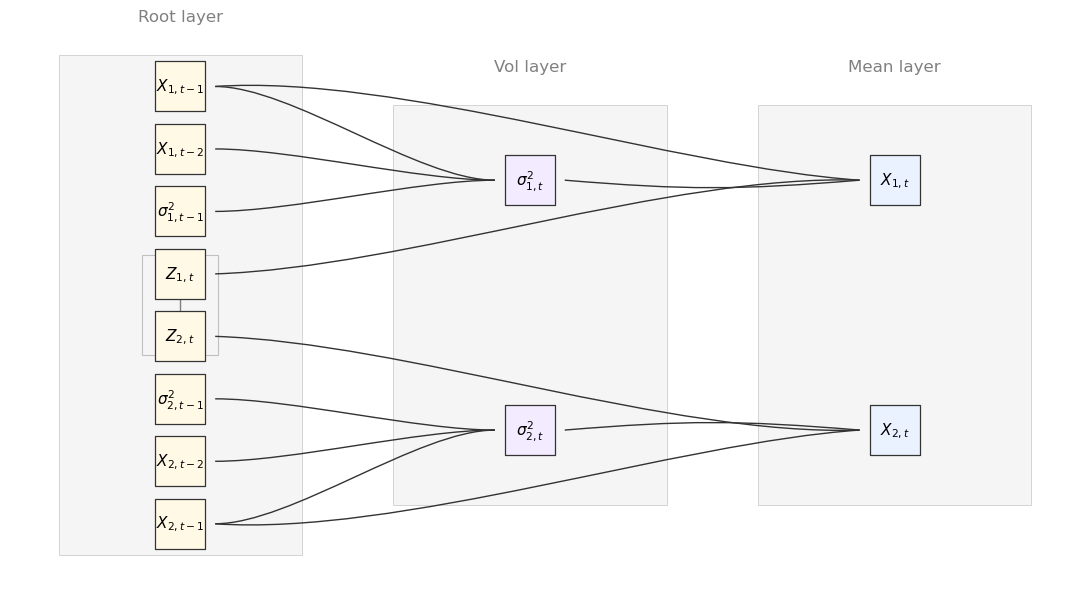

In [34]:
# filename: dependency_graph_2d_clean_titles_outside.py
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.path import Path

G = nx.DiGraph()

# ---------- Nodes ----------
root_1 = ["X1_tm2", "X1_tm1", "s1_tm1", "Z1_t"]
root_2 = ["Z2_t", "X2_tm2", "X2_tm1", "s2_tm1"]
vol     = ["s1_t", "s2_t"]
mean    = ["X1_t", "X2_t"]
G.add_nodes_from(root_1 + root_2 + vol + mean)

# ---------- Edges ----------
G.add_edges_from([
    ("X1_tm2", "s1_t"), ("X1_tm1", "s1_t"), ("s1_tm1", "s1_t"),
    ("X2_tm2", "s2_t"), ("X2_tm1", "s2_t"), ("s2_tm1", "s2_t"),
])
G.add_edges_from([("X1_tm1", "X1_t"), ("X2_tm1", "X2_t")])
G.add_edges_from([("s1_t", "X1_t"), ("s2_t", "X2_t")])
G.add_edges_from([("Z1_t", "X1_t"), ("Z2_t", "X2_t")])

# ---------- Labels ----------
labels = {
    "X1_tm2": r"$X_{1,t-2}$", "X1_tm1": r"$X_{1,t-1}$", "s1_tm1": r"$\sigma^2_{1,t-1}$",
    "X2_tm2": r"$X_{2,t-2}$", "X2_tm1": r"$X_{2,t-1}$", "s2_tm1": r"$\sigma^2_{2,t-1}$",
    "Z1_t": r"$Z_{1,t}$", "Z2_t": r"$Z_{2,t}$",
    "s1_t": r"$\sigma^2_{1,t}$", "s2_t": r"$\sigma^2_{2,t}$",
    "X1_t": r"$X_{1,t}$", "X2_t": r"$X_{2,t}$",
}

# ---------- Panel anchors ----------
x_root, x_vol, x_mean = 0.0, 2.4, 4.8
x_root_center = x_root + 0.2
x_vol_center  = x_vol  + 0.1
x_mean_center = x_mean + 0.1

# ---------- Node positions ----------
y1, y2 = 3.0, 1.0
yc, step = 2.0, 0.5

pos = {
    "X1_tm1": (x_root_center, yc + 3.5*step),
    "X1_tm2": (x_root_center, yc + 2.5*step),
    "s1_tm1": (x_root_center, yc + 1.5*step),
    "Z1_t":   (x_root_center, yc + 0.5*step),
    "Z2_t":   (x_root_center, yc - 0.5*step),
    "s2_tm1": (x_root_center, yc - 1.5*step),
    "X2_tm2": (x_root_center, yc - 2.5*step),
    "X2_tm1": (x_root_center, yc - 3.5*step),
    "s1_t": (x_vol_center,  y1),
    "s2_t": (x_vol_center,  y2),
    "X1_t": (x_mean_center, y1),
    "X2_t": (x_mean_center, y2),
}

# ---------- Curved edge helper ----------
def bezier_edge_to_edge(ax, a, b, bend=0.6, lift=0.0, lw=1.0, node_half_width=0.23):
    (x0, y0), (x1, y1) = a, b
    start = (x0 + node_half_width, y0)
    end   = (x1 - node_half_width, y1)
    p1 = (start[0] + bend, start[1] + lift)
    p2 = (end[0]   - bend, end[1]   + lift)
    path = Path([start, p1, p2, end], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    ax.add_patch(PathPatch(path, lw=lw, edgecolor="#333333", facecolor="none", zorder=2))

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(11, 6))
ax.set_axis_off()

# Panels (titles OUTSIDE above the box)
def band(x0, x1, y0, y1, label):
    r = Rectangle((x0, y0), x1-x0, y1-y0,
                  linewidth=0.7, edgecolor="lightgray",
                  facecolor="whitesmoke", zorder=0)
    ax.add_patch(r)
    ax.text((x0+x1)/2, y1+0.25, label, ha="center", va="bottom",
            fontsize=12, color="gray")  # now ABOVE box

band(x_root-0.6, x_root+1.0, 0.0, 4.0, "Root layer")
band(x_vol -0.8, x_vol +1.0, 0.4, 3.6, "Vol layer")
band(x_mean-0.8, x_mean+1.0, 0.4, 3.6, "Mean layer")

# Shock box around Z's
z_top_y, z_bottom_y = yc + 0.8*step, yc - 0.8*step
ax.add_patch(Rectangle((x_root_center-0.25, z_bottom_y), 0.5, z_top_y - z_bottom_y,
                       linewidth=0.8, edgecolor="silver", facecolor="none", zorder=1))
ax.add_patch(PathPatch(Path([pos["Z1_t"], pos["Z2_t"]], [Path.MOVETO, Path.LINETO]),
                       lw=1.0, edgecolor="gray", zorder=1.5))

# Nodes
nx.draw_networkx_nodes(G, pos, nodelist=root_1+root_2, node_color="#fff9e6",
                       edgecolors="#333333", node_size=1300, node_shape="s", linewidths=0.9)
nx.draw_networkx_nodes(G, pos, nodelist=vol, node_color="#f3ebff",
                       edgecolors="#333333", node_size=1300, node_shape="s", linewidths=0.9)
nx.draw_networkx_nodes(G, pos, nodelist=mean, node_color="#eaf2ff",
                       edgecolors="#333333", node_size=1300, node_shape="s", linewidths=0.9)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=11)

# Edges
for u in ["X1_tm2", "X1_tm1", "s1_tm1"]:
    bezier_edge_to_edge(ax, pos[u], pos["s1_t"], bend=0.5)
for u in ["X2_tm2", "X2_tm1", "s2_tm1"]:
    bezier_edge_to_edge(ax, pos[u], pos["s2_t"], bend=0.5)

bezier_edge_to_edge(ax, pos["X1_tm1"], pos["X1_t"], bend=1.2, lift=+0.10)
bezier_edge_to_edge(ax, pos["X2_tm1"], pos["X2_t"], bend=1.2, lift=-0.10)
bezier_edge_to_edge(ax, pos["s1_t"], pos["X1_t"], bend=0.8, lift=-0.08)
bezier_edge_to_edge(ax, pos["s2_t"], pos["X2_t"], bend=0.8, lift=+0.08)
bezier_edge_to_edge(ax, pos["Z1_t"], pos["X1_t"], bend=1.25, lift=+0.05)
bezier_edge_to_edge(ax, pos["Z2_t"], pos["X2_t"], bend=1.25, lift=-0.05)

plt.tight_layout()
plt.savefig("dependency_graph_2d_clean_titles_outside.png", dpi=240, bbox_inches="tight")
plt.savefig("dependency_graph_2d_clean_titles_outside.svg", bbox_inches="tight")
print("Saved dependency_graph_2d_clean_titles_outside.[png|svg]")
